<p>
  <b>AI Lab: Deep Learning for Computer Vision</b><br>
  <b><a href="https://www.wqu.edu/">WorldQuant University</a></b>
</p>

<div class="alert alert-success" role="alert">
  <p>
    <center><b>Usage Guidelines</b></center>
  </p>
  <p>
    This file is licensed under <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International</a>.
  </p>
  <p>
    You <b>can</b>:
    <ul>
      <li><span style="color: green">✓</span> Download this file</li>
      <li><span style="color: green">✓</span> Post this file in public repositories</li>
    </ul>
    You <b>must always</b>:
    <ul>
      <li><span style="color: green">✓</span> Give credit to <a href="https://www.wqu.edu/">WorldQuant University</a> for the creation of this file</li>
      <li><span style="color: green">✓</span> Provide a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">link to the license</a></li>
    </ul>
    You <b>cannot</b>:
    <ul>
      <li><span style="color: red">✗</span> Create derivatives or adaptations of this file</li>
      <li><span style="color: red">✗</span> Use this file for commercial purposes</li>
    </ul>
  </p>
  <p>
    Failure to follow these guidelines is a violation of your terms of service and could lead to your expulsion from WorldQuant University and the revocation your certificate.
  </p>
</div>

### Getting Ready

Just like in the last lesson, there are a few things we need to do before we can begin. We'll start by importing the packages we'll need for this lesson.

In [1]:
import os
import sys
from collections import Counter

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
import torchvision
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from tqdm.version import __version__ as tqdm__version__

torch.backends.cudnn.deterministic = True

Next, we'll print out the version numbers for our libraries, including Python. We want to make sure that anyone who reviews our work knows exactly what software we used in case they want to reproduce our analysis.

In [2]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("CV2 version : ", cv2.__version__)
print("matplotlib version : ", matplotlib.__version__)
print("numpy version : ", np.__version__)
print("torch version : ", torch.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("torchvision version : ", torchvision.__version__)
print("PIL version : ", PIL.__version__)
print("scikit-learn version: ", sklearn.__version__)
print("tqdm version: ", tqdm__version__)

Platform: linux
Python version: 3.11.0 (main, Nov 15 2022, 20:12:54) [GCC 10.2.1 20210110]
---
CV2 version :  4.10.0
matplotlib version :  3.9.2
numpy version :  1.26.3
torch version :  2.2.2+cu121
torchinfo version :  1.8.0
torchvision version :  0.17.2+cu121
PIL version :  10.2.0
scikit-learn version:  1.5.2
tqdm version:  4.66.5


Last (this is a new step), we'll check if GPUs are available. Remember from the last lesson that GPUs allow us to build our models more quickly compared to the CPU. Some computers come with GPUs, which allow for bigger and faster model building. In PyTorch, the `cuda` package is used to access GPUs on Linux and Windows machines; `mps` is used on Macs. 

We'll use the `device` variable later to set the location of our data and model.

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


### Exploring Our Data

Our goal is to build a model that can identify wildlife in photos taken by automated surveillance systems, also called "camera traps."

We downloaded the data in the previous lesson. Here, we'll use the data in the `data_binary` folder. It's already broken up in a training set in `train`.

**Task 1.3.1:** Assign `train_dir` the path to the training data. Follow the pattern of `data_dir`.

In [4]:
data_dir = os.path.join("data_p1", "data_binary")
train_dir = os.path.join(data_dir,"train")

print("Data Directory:", data_dir)
print("Training Data Directory:", train_dir)

Data Directory: data_p1/data_binary
Training Data Directory: data_p1/data_binary/train


Since we're doing binary classification, we'll have two different labels. The data for each label is separated into their own folder. The name of the folder corresponds to the name of the label.

In [5]:
labels = os.listdir(train_dir)
labels

['hog', 'blank']

From the names, our training data falls into two classes. We have either an image of a hog or an image where there's no animal present (`"blank"`). We want our model to distinguish between these two types of images. We call this task binary classification.

Let's find out how many images we have for each label. We can do so with `listdir` function, which lists the names of all files in a folder. We can then check the length of the returned list.

**Task 1.3.2:**  Determine the number of blank images in the training data and assign the result to `blank_images`. Use the code for `hog_images` as a model.

In [6]:
hog_path = os.path.join(train_dir, "hog")
hog_images = os.listdir(hog_path)
print("length of hog images: ", len(hog_images))

blank_path = os.path.join(train_dir, "blank")
blank_images = os.listdir(blank_path)
print("length of blank images: ", len(blank_images))


length of hog images:  978
length of blank images:  2213


Looks like there are more "blank" than "hog" images. This makes sense as there might be a lot of false positives where the camera goes off when no animal is in the frame.

Let's look at the path of one image for each label.

**Task 1.3.3:** Display the path of one image of the blank class. We've illustrated how this is done for the hog class.

In [7]:
hog_image_name = hog_images[0]
print(hog_image_name)

hog_image_path = os.path.join(hog_path, hog_image_name)
print(hog_image_path)

blank_image_name = blank_images[1]
print(blank_image_name)

blank_image_path = os.path.join(blank_path, blank_image_name)
print(blank_image_path)

ZJ012491.jpg
data_p1/data_binary/train/hog/ZJ012491.jpg
ZJ001885.jpg
data_p1/data_binary/train/blank/ZJ001885.jpg


 Recall how the mode describes the pixel data of the images. In the past, we've seen both grayscale and red green blue (RGB). It's also important to check out the size of the images.

**Task 1.3.4:** Print out the mode and size for the blank image sample. We've shown how this is done for the hog sample.

In [8]:
hog_img_pil = Image.open(hog_image_path)
print("Hog image: ", hog_img_pil.mode, hog_img_pil.size)

blank_img_pil = Image.open(blank_image_path)
print("Blank image: ", blank_img_pil.mode, blank_img_pil.size)

Hog image:  L (360, 240)
Blank image:  RGB (640, 360)


Let's now see each image using the Pillow package.

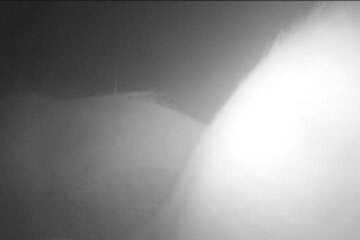

In [9]:
hog_img_pil

Do you see the hog? We see something in the frame that could possibly be an animal. At least it'll take us some time to decide if it's really a hog. We're starting to see the advantage of having a computer identify if there's a hog in the image. A human manually reviewing images may have missed the hog, especially if they're going through the images quickly. Of course, we need to actually build a system that will perform well and identify images where the hog can be easily missed.

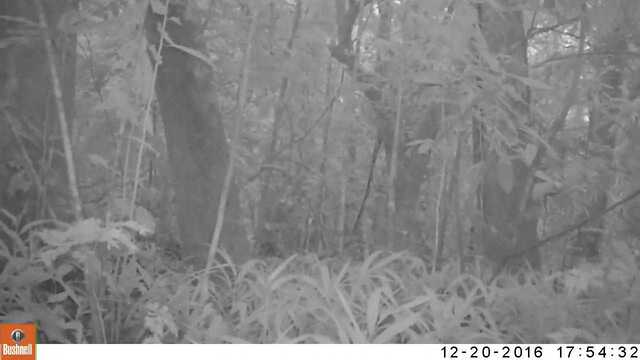

In [10]:
blank_img_pil

There doesn't appear to be a hog in this image. A computer can quickly return whether the image is blank but a human may spend several seconds or even longer to make sure there's no hog.

### Preparing Our Data

We need to make sure all of our images are in the same mode. We want to make sure they're in RGB format. If not, we'll need to convert them. In fact, our sample hog image was in grayscale, denoted by the "L" for its mode value. We'll create a custom transformer that will convert an image to RGB mode if it's not.

In [11]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

We're using the special method `__call__` which makes it a callable class. In other words, it acts like a function. We need this method to use `ConvertToRGB` in our preprocessing pipeline.

Remember how we previously used utilities from the `torchvision` package. We'll use `transforms.Compose` to create a "pipeline" of preprocessing sets. The steps defined (in order) will be:

* Convert image (if needed) to RGB
* Resize the image
* Convert the images to PyTorch tensors

Afterwards, we'll load the data and apply the transformation pipeline.

**Task 1.3.5:** Add the missing last step where we convert images to PyTorch tensors. In a previous lesson we used `transform.ToTensor` to accomplish the conversion.

In [12]:
# Define transformation to apply to the images
transform = transforms.Compose(
    [
        ConvertToRGB(),  # Convert images to RGB format if not already
        transforms.Resize((224, 224)),  # Resize images to 224x224
        # Convert images to tensors
        transforms.ToTensor()
    ]
)

print(type(transform))
print(transform)

<class 'torchvision.transforms.transforms.Compose'>
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


<div class="alert alert-info" role="alert">
You might be wondering why we need to resize the images. Unfortunately, the images are not all the same shape.  You might have remembered how the two sample images we looked at were different shapes. We saw this when we opened the images in the notebook. Inconsistent image dimensions is common when we gather data from various sources. For deep learning, we need a lot of data so we can't be too picky and remove data that differ in shape. The solution to the inconsistent shape is convert all images to a standard size.
</div>

Now we'll load the data by using `datasets` from the `torchvision` package.

In [13]:
# Load the dataset using `ImageFolder`
dataset = datasets.ImageFolder(root=train_dir, transform=transform)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 3191
    Root location: data_p1/data_binary/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


The `dataset` object has the attribute `.classes` which returns a list of distinct classes.

In [14]:
dataset.classes

['blank', 'hog']

The `.imgs` attribute is a list of tuples of path to image and label. The label value will be a number. Since we're doing binary classification, there will only be two distinct numbers. Those numbers are 0 and 1.

**Task 1.3.6:** Prove that the only distinct values of `im` are `0` and `1`. You should use a `set` data structure.

In [16]:
im = dataset.imgs
print(im[0])

distinct_classes = {x[1] for x in im}
print(distinct_classes)

('data_p1/data_binary/train/blank/ZJ000013.jpg', 0)
{0, 1}


As we're doing supervised machine learning, we need to perform a train/validation split. A validation set is used to help choose our model when training. 

It's typical to use an 80/20 split. The `random_split` function will help us perform the split.

In [17]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=g)

Now let's inspect the sizes of the splits.

**Task 1.3.7:**  Print out the length of the validation dataset. We've done so for the training set.

In [18]:
print(f"Length of training set: {len(train_dataset)}")
print(f"Length of validation set: {len(val_dataset)}")


Length of training set: 2553
Length of validation set: 638


It's good to explore the data. We'll create a visualization to show the breakdown of the two classes. The function below goes through the dataset and counts how many images are in each class.

In [19]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

In [20]:
train_counts = class_counts(train_dataset)
train_counts

  0%|          | 0/2553 [00:00<?, ?it/s]

blank    1749
hog       804
dtype: int64

The pandas built-in plotting can make a nice visualization out of it.

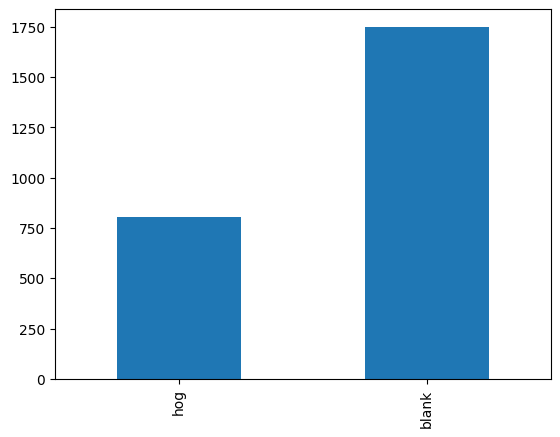

In [21]:
train_counts.sort_values().plot(kind="bar");

**Task 1.3.8:** Use the function and pandas to make the same plot for the validation data.

  0%|          | 0/638 [00:00<?, ?it/s]

<Axes: >

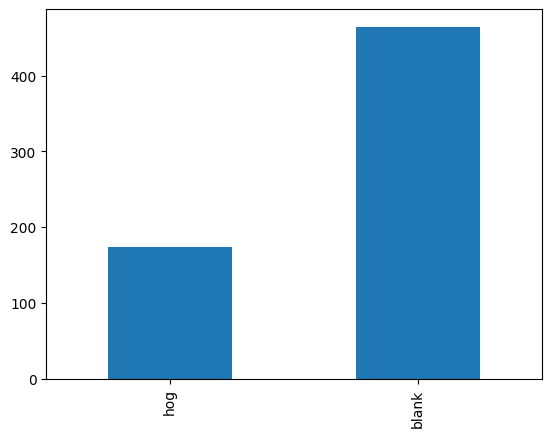

In [22]:
val_counts = class_counts(val_dataset)

# Make a bar chart from the function output
val_counts.sort_values().plot(kind="bar")

From both visualizations, we see two things:
* About two-thirds of the data is the "blank" label.
* Both the training and validation set are similarly distributed.

We're closer to training a model. The next step is to create `DataLoader` objects. These objects are iterables that work well with PyTorch when training. We'll use a batch size of 32, which is standard for neural networks. The main difference between the `DataLoader` for training and validation is that shuffling is turned on for training. Turning on shuffling for the training data randomly rearranges the data after we have gone over all of the batches. Shuffling prevents any particular batch of data from having too much influence on the training.

**Task 1.3.9:** Create the validation loader. Make sure to set shuffling to be off.

In [23]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=g)

print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


Now with the `DataLoader` objects, we'll show they're iterables by using `iter` and `next`. There's no need to do this all the time, we're just exploring how PyTorch will make use of the `DataLoader` objects. `iter` returns an _iterator_. This iterator will give us the _next_ value in an iteration.

We'll get one sample batch of images and labels and make sure the dimensions match what we expect. One batch of images should be a 4D tensor with dimension `[32, 3, 224, 224]`. This is because we set the batch to 32, we have RGB images that have 3 color channels, and our images have height 224 and width 224. 

One batch of labels should be a one dimensional tensor of length 32.

**Task 1.3.10:** Print the shape of a batch of images and the shape of a batch of labels.

In [24]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# This gives you [batch_size, channels, height, width] for images
image_shape = images.shape
print("Shape of batch of images", image_shape)

# This gives you [batch_size] for labels
label_shape = labels.shape
print("Shape of batch of labels:", label_shape)

Shape of batch of images torch.Size([32, 3, 224, 224])
Shape of batch of labels: torch.Size([32])


Let's examine the `labels` tensor to make sure it's nothing but ones and zeros.

In [25]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 0, 1])

### Building a Shallow Neural Network

We're now ready to create our first neural network model. The model will be a shallow fully connected network. It'll not have too many layers, in fact, it'll have four. Here's the architecture:
- The input layer
- Two hidden layers
- The output layer

The image below is an example of our architecture. Note, the image shows fewer neurons than what we'll build as it's hard to visualize a model with many neurons. The important part is that we have an input layer, two hidden layers, and two nodes for the output layer.


<img src="./full_nn_two_hidden_layers.png" alt="Shallow neural network with two hidden layers" width="400"/>

Our input data are images. Each image is a 3D tensor. The shape is 3 x 224 x 224. But there's one problem. This neural network can't accept images in two dimensions. We need to first _flatten_ the image. As you can imagine, we lose some information when we flatten the image. In a later lesson, we'll see a better neural network architecture at preserving the spatial relational data that is lost when flattening.

Let's walk through the flattening process with `images`. Convenient for us, `images` is already a PyTorch tensor. In the previous task, we determined that its shape is $32 \times 3 \times 224 \times 224$. The first dimension represents the number of images we have in the batch. If we flatten our images, we should get a tensor of 32 x 150528. Why 150528? It's the product of $3 \times 224 \times 224$. Each image, instead of being three dimensional, will now just have one dimension.

**Task 1.3.11:** Flatten the image and print out the resulting shape of the tensor. Use the `nn.Flatten` class to flatten.

In [28]:
flatten = nn.Flatten()
tensor_flatten = flatten(images)

# Print the shape of the flattened tensor
print(f"Shape of the flattened tensor: {tensor_flatten.shape}")

Shape of the flattened tensor: torch.Size([32, 150528])


Flattening the images is the first step or layer of our model. However, it'll be tedious if we have to manually apply all the layers of our network. Instead we'll use the `nn.Sequential` class from PyTorch.  It offers an easy way to define the architecture.  As the name suggests, this class takes a sequence of layers and runs the data through them in order.  The following cell mostly defines the model, but we intentionally left out the output layer for now. We will add it later in the next task (discussed below).

In [29]:
# Image size from our transformer
height = 224
width = 224

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * height * width, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
)

print("model type:", type(model))
print("model structure:")
print(model)

model type: <class 'torch.nn.modules.container.Sequential'>
model structure:
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
)


Now let's add the last layer needed for the model. That layer is a `nn.Linear` with an input size of 128 and an output size of 2. Additional layers can be added/appended to a model with `model.append`. 

**Task 1.3.12:** Create the output layer. The last line of the cell below will append it to the model.

In [30]:
output_layer = nn.Linear(128,2)
model.append(output_layer)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)


We can see three different types of layers being used:
- `nn.Flatten` flattens the three-dimensional input tensors to the one-dimensional tensors that the next layers expect.
- `nn.Linear` is a standard dense, or fully-connected, layer.  It takes two arguments, the number of inputs coming into this layer and the number of outputs produced by this layer.
- `nn.ReLU` performs the _rectified linear unit_ activation.  Activation functions are necessary for neural networks to work, and ReLU is a popular choice.

The last `nn.Linear` is our output layer.  It must have 128 inputs, to match the output of the preceding layer, and it must have 2 outputs to match the two classes. Note that there's no activation function applied after the output layer.  This means that the outputs of this layer are the _logits_.  Later on, these logits will be the input to a normalization function, called softmax in this case, that will turn the logits into probabilities.

The model will run much more quickly on the GPU.

**Task 1.3.13:**  Use `model.to` function to place the model on `device`.

In [31]:
model.to(device)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)


Great! The output of the previous cell outlines our architecture. We can get a more detailed look with the `summary` function.

In [33]:
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 2]                   --
├─Flatten: 1-1                           [32, 150528]              --
├─Linear: 1-2                            [32, 512]                 77,070,848
├─ReLU: 1-3                              [32, 512]                 --
├─Linear: 1-4                            [32, 128]                 65,664
├─ReLU: 1-5                              [32, 128]                 --
├─Linear: 1-6                            [32, 2]                   258
Total params: 77,136,770
Trainable params: 77,136,770
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.47
Input size (MB): 19.27
Forward/backward pass size (MB): 0.16
Params size (MB): 308.55
Estimated Total Size (MB): 327.98

Several things to notice from above:
* how many parameters we have for each layer
* how many multiplication and addition operations we're going to perform
* the total size of our model

Even for a shallow network of just two hidden layers we have over 77 million parameters. This number far exceeds anything you may have worked with in machine learning models that aren't neural networks. You can begin to see why we need to use a specialized package for building and training neural network models.

### Training Our Model

There are several pieces we need beyond the model object. First, we need to define a loss function. The loss function measures how well our model does for a given set of model parameters. The chosen loss function, cross-entropy, is pretty standard. It's the same loss function used for simpler machine learning models such as logistic regression.  Note that this function expects the input to be logits from our model.

In [34]:
loss_fn = nn.CrossEntropyLoss()

We also need an optimizer.  This will adjust the model's parameters to try to minimize the loss function.  We've chosen the Adam optimizer, a popular optimizer. The Adam optimizer is a gradient based optimizer like stochastic gradient descent. The Adam optimizer has additional features that make it less likely to get stuck in a local minimum. It converges to a better state faster than standard stochastic gradient descent. The `optim.Adam` class is initialized with the model parameters through `model.parameters`. An optional argument is the learning rate `lr`. This controls how large the step sizes are in gradient descent. Keeping the default value will be fine for our purposes. We've explicitly specified the default value in this case.

In [35]:
# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

Now we'll create a function called `train_epoch` that encapsulates the training process. The code is daunting at first but we're going to break it down. The function accepts
- `model`: The PyTorch model we built with a specific architecture
- `optimizer`: The optimizer that will be used to best adjust the model weights
- `loss_fn`: The loss function that the optimizer is trying to minimize
- `data_loader`: The `DataLoader` object for the training dataset that makes it easy to iterate over batches
- `device`: The device where we're going to place the tensors

The function returns the average loss function on the training data over the entire epoch.  Later, we'll use this to see if the model is making progress in the training process.

In [36]:
def train_epoch(model, optimizer, loss_fn, data_loader, device="cpu"):
    # We'll report the loss function's average value at the end of the epoch.
    training_loss = 0.0

    # The train method simply sets the model in training mode. No training
    # has happened.
    model.train()

    # We iterate over all batches in the training set to complete one epoch
    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        # Sets the gradients to zero. We need to do this every time.
        optimizer.zero_grad()

        # Unpack images (X) and labels (y) from the batch and add those
        # tensors to the specified device.
        inputs = inputs.to(device)
        targets = targets.to(device)

        # We make a forward pass through the network and obtain the logits.
        # With the logits, we can calculate our loss.
        output = model(inputs)
        loss = loss_fn(output, targets)

        # After calculating our loss, we calculate the numerical value of
        # the derivative of our loss function with respect to all the
        # trainable model weights. Once we have the gradients calculated,
        # we let the optimizer take a "step", in other words, update or
        # adjust the model weights.
        loss.backward()
        optimizer.step()

        # We increment the training loss for the current batch
        training_loss += loss.data.item() * inputs.size(0)

    # We calculate the training loss over the completed epoch
    return training_loss / len(data_loader.dataset)

<div class="alert alert-info" role="alert">
The <code>tqdm</code> function that is wrapped around the <code>data_loader</code> will give us a progress bar that fills up as we process the data.  It's not necessary for the training process.  It's just there to reassure us that something is actually happening!
</div>

We'll train the model for one epoch. The `train_epoch` function returns the average training loss, cross-entropy, for the epoch.

In [37]:
loss_value = train_epoch(model, optimizer, loss_fn, train_loader, device)
print(f"The average loss during the training epoch was {loss_value:.2f}.")

Training:   0%|          | 0/80 [00:00<?, ?it/s]

The average loss during the training epoch was 3.83.


A nice feature of neural networks is that when we do another training run, it doesn't start training from scratch. In other words, training resumes from the current weights and continues to adjust the weights to improve the model's performance.

Now it's your turn to train the model!

**Task 1.3.14:** Train the model using a single epoch with the *training data*. Print out the model's loss.

In [38]:
loss_value = train_epoch(model, optimizer, loss_fn, train_loader, device)
print(f"The average loss during the training epoch was {loss_value:.2f}.")

Training:   0%|          | 0/80 [00:00<?, ?it/s]

The average loss during the training epoch was 0.53.


The loss function we're using in this problem, the cross-entropy, is difficult for humans to interpret.  We know that lower is better, but is that number good or bad?  To help us humans judge, we'll calculate the accuracy of the model, the fraction of predictions it gets right.  To do that, we need the model to make predictions.

The following function will make a prediction for each row of data in `data_loader`, using `model`.  As with the `train_epoch` function above, it's a bit daunting.  The comments explain what each section does.

In [39]:
def predict(model, data_loader, device="cpu"):
    # This tensor will store all of the predictions.
    all_probs = torch.tensor([]).to(device)

    # We set the model to evaluation mode. This mode is the opposite of
    # train mode we set in the train_epoch function.
    model.eval()

    # Since we're not training, we don't need any gradient calculations.
    # This tells PyTorch not to calculate any gradients, which speeds up
    # some calculations.
    with torch.no_grad():

        # Again, we iterate over the batches in the data loader and feed
        # them into the model for the forward pass.
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            # The model produces the logits.  This softmax function turns the
            # logits into probabilities.  These probabilities are concatenated
            # into the `all_probs` tensor.
            probs = F.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)

    return all_probs

We'll demo using the function above with the *training data*.

In [40]:
probabilities_train = predict(model, train_loader, device)
print(probabilities_train.shape)

Predicting:   0%|          | 0/80 [00:00<?, ?it/s]

torch.Size([2553, 2])


The first dimension of this tensor is the same as the size of our data set because it has made a prediction for each row.

In [41]:
len(train_loader.dataset)

2553

**Task 1.3.15:** Make a prediction for each row of the *validation data*.

In [42]:
probabilities_val = predict(model, val_loader, device)
print(probabilities_val.shape)

Predicting:   0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([638, 2])


What are the predictions that `predict` returned? Let's take a closer look.

In [43]:
print(probabilities_train[0])

tensor([0.1385, 0.8615], device='cuda:0')


We see two numbers here.  The first is the probability that this image is of the first class ("blank") and the second is the probability that it's of the second class ("hog"). Because these are the only two possibilities, they should add up to one.

In [44]:
probabilities_train[0].sum()

tensor(1., device='cuda:0')

**Task 1.3.16:** Print out the prediction for the first row of the validation set.

In [45]:
# Print the probabilities of the first row
print(probabilities_val[0])

tensor([0.5775, 0.4225], device='cuda:0')


**Task 1.3.17:** Sum the probabilities to show that they indeed sum to one.

In [46]:
total_probability = probabilities_val[0].sum()
print(f"Sum of probabilities: {total_probability.item()}")

Sum of probabilities: 1.0


To make a prediction from these probabilities, we predict the class with the highest probability for each row.  This can be done with the `torch.argmax` function, like so:

In [47]:
predictions_train = torch.argmax(probabilities_train, dim=1)

print(f"Predictions shape: {predictions_train.shape}")
print(f"First 10 predictions: {predictions_train[:10]}")

Predictions shape: torch.Size([2553])
First 10 predictions: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


**Task 1.3.18:** Predict the most likely class label using the validation set.

In [48]:
predictions_val = torch.argmax(probabilities_val, dim=1)

print(f"Predictions shape: {predictions_val.shape}")
print(f"First 10 predictions: {predictions_val[:10]}")

Predictions shape: torch.Size([638])
First 10 predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


We'll compare the training set predictions to the actual class labels for the training set. The `torch.eq` function will help with this. We'll find the fraction that are correct. This is the accuracy.

In [49]:
targets_train = torch.cat([labels for _, labels in train_loader]).to(device)
is_correct_train = torch.eq(predictions_train, targets_train)
total_correct_train = torch.sum(is_correct_train).item()
accuracy_train = total_correct_train / len(train_loader.dataset)

print(f"Accuracy on the training data: {accuracy_train}")

Accuracy on the training data: 0.6341558950254602


**Task 1.3.19:**  Calculate the accuracy of the model on the validation set.

In [50]:
targets_val = torch.cat([labels for _, labels in val_loader]).to(device)
is_correct_val = torch.eq(predictions_val,targets_val)
total_correct_val = torch.sum(is_correct_val).item()
accuracy_val = total_correct_val/len(val_loader.dataset)

print(f"Accuracy on the validation data: {accuracy_val}")

Accuracy on the validation data: 0.8134796238244514


There was a lot of work we did to get the accuracy. It's more efficient to do this calculation batch by batch. It's best we wrap that code into a function. The `score` function, below, does just that. It's very similar to the prediction function, but instead of gathering all the predictions, it just calculates the number of correct predictions in each batch.  It also calculates the loss function over the whole batch. We'll use this to compare the loss function value on the training set and the validation set, to understand if there's any overfitting.

In [51]:
def score(model, data_loader, loss_fn, device="cpu"):
    # Initialize the total loss (cross entropy) and the number of correct
    # predictions. We'll increment these values as we loop through the
    # data.
    total_loss = 0
    total_correct = 0

    # We set the model to evaluation mode. This mode is the opposite of
    # train mode we set in the train_epoch function.
    model.eval()

    # Since we're not training, we don't need any gradient calculations.
    # This tells PyTorch not to calculate any gradients, which speeds up
    # some calculations.
    with torch.no_grad():
        # We iterate over the batches in the data loader and feed
        # them into the model for the forward pass.
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            # Calculating the loss function for this batch
            targets = targets.to(device)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            # Calculating the correct predictions for this batch
            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()

    return total_loss / len(data_loader.dataset), total_correct / len(
        data_loader.dataset
    )

In the cell below, we show how easy it's to use the `score` function.

In [52]:
loss_train, accuracy_train = score(model, train_loader, loss_fn, device)
print(f"Training accuracy from score function: {accuracy_train}")

Scoring:   0%|          | 0/80 [00:00<?, ?it/s]

Training accuracy from score function: 0.7931844888366627


**Task 1.3.20:** Use the `score` function on the validation data, and check that we get the same accuracy as we computed above.

In [53]:
loss_val, accuracy_val = score(model, val_loader, loss_fn, device)
print(f"Validation accuracy from score function: {accuracy_val}")

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Validation accuracy from score function: 0.8134796238244514


We now have the pieces we need for our training loop.  This loop will run over a number of epochs, calling the `train_epoch` function and the `score` function, and printing out some diagnostic information so we can see how the training is going.

In [54]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):

    for epoch in range(1, epochs + 1):
        # Run train_epoch once, and capture the training loss.
        training_loss = train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Score the model on the validation data.
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)

        print(
            f"Epoch: {epoch}, Training Loss: {training_loss:.2f}, "
            f"Validation Loss: {validation_loss:.2f}, Validation Accuracy: {validation_accuracy:.2f}"
        )

<div class="alert alert-info" role="alert"> <strong>Regarding Model Training Times</strong>

In the next few cells you'll experience training a Deep Learning model for the first time. Training models is computationally intensive and can be very time-consuming. The particular model we're dealing with in this notebook is small enough that training takes less than 5 minutes.

But in further lessons, training times could last well over one hour.

To streamline your learning experience, we are including pre-trained models that you can just load and use without the need to sit and wait for training to finish. The cells to load the model are purposely marked, so you won't miss them.

You are free to experience training the models by yourself, <strong>but make sure you load the pre-trained model before continuing, as the graded tasks will depend on this particular model</strong>.

Also, are you curious how we have saved the trained model? It'll be explained in detail at the end of this lesson.
</div>

Now that we've defined the function for training, let's use it.

In [55]:
train(model, optimizer, loss_fn, train_loader, val_loader, epochs=5, device=device)

Training:   0%|          | 0/80 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.51, Validation Loss: 0.49, Validation Accuracy: 0.79


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.46, Validation Loss: 0.46, Validation Accuracy: 0.81


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.49, Validation Loss: 1.06, Validation Accuracy: 0.49


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.50, Validation Loss: 0.52, Validation Accuracy: 0.77


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.43, Validation Loss: 0.36, Validation Accuracy: 0.85


Notice how the training loss goes down and the accuracy goes up after each epoch. Can we do better? Let's try. Recall how a nice feature of neural networks is that we can pause and continue training without having to start from scratch.

**Task 1.3.21:** Continue training the model for two more epochs.

In [56]:

train(model, optimizer, loss_fn, train_loader, val_loader, epochs=2, device=device)

Training:   0%|          | 0/80 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.46, Validation Loss: 0.40, Validation Accuracy: 0.85


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.37, Validation Loss: 0.32, Validation Accuracy: 0.88


How many epochs should we train for? To answer that question, we need to balance between underfitting and overfitting. For now, we can train for more epochs until we observe the validation score is not improving or is actually getting worse. In future projects, we'll create a visualization called a learning curve to help us decide the correct number of epochs.

<div class="alert alert-warning" role="alert">
<strong>Make sure that you load the pre-trained model running the cell below.</strong>
</div>

Load the pre-trained model with the following line:

In [57]:
model = torch.load("model/trained_model.pth", weights_only=False)

Now with our model trained we want to see how well it performs.

**Task 1.3.22:** Make a prediction for each image in the validation set.

In [58]:
probabilities_val = predict(model, val_loader, device=device)
predictions_val = torch.argmax(probabilities_val, dim=1)
print(predictions_val[:10])

Predicting:   0%|          | 0/20 [00:00<?, ?it/s]

tensor([1, 0, 0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')


Accuracy only gives us a simplified view of how well the model performed. We'd like to see how many of the mistakes were from predicting a hog when it's really not a hog, and vice versus. In short, we want a confusion matrix.

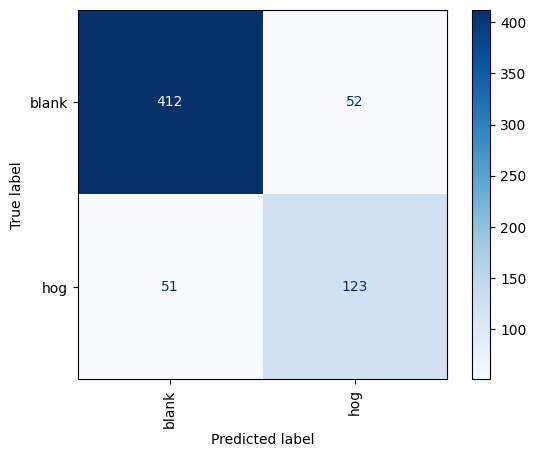

In [60]:
cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["blank", "hog"])

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical");

69% of our validation data is the blank class. If our errors are proportionally distributed, we should expect about 69% of our errors to be when we predict "blank" instead of hog. Are the errors uniformly distributed?

Let's run our model on one chosen image of a hog.

In [61]:
img_path = os.path.join(data_dir, "train/hog/ZJ000072.jpg")

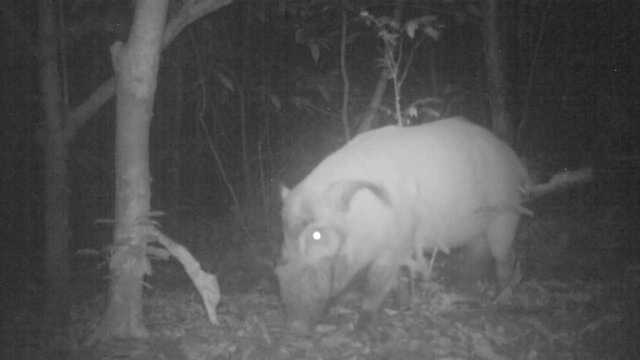

In [62]:
from IPython.display import Image as JupyterImage
JupyterImage(filename=img_path) 

In [63]:
labels = ["blank", "hog"]

img = Image.open(os.path.join(data_dir, "train/hog/ZJ000072.jpg"))
img = transform(img).to(device)
img = torch.unsqueeze(img, 0)

model.eval()
prediction = F.softmax(model(img), dim=1)
prediction = prediction.argmax()
print(labels[prediction])

hog


Our model predicted correctly! But how confident was it's prediction? Neural networks are probabilistic classifiers. The probabilities are obtained by running the model outputs through the softmax function.

In [64]:
F.softmax(model(img), dim=1)

tensor([[0.0129, 0.9871]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

Looks like our model determines that the probability the image shows a hog is much greater than 50%. It's fairly confident that it's correct. These probabilities are useful as they can help us decide whether we should take any action based on the model's prediction. For example, if images are being collected and analyzed in real time, we may only want to alert conservation staff if we're really confident we have spotted a hog.

<div class="alert alert-info" role="alert">
The training process relies on randomness. There are various sources for this randomness. For example, we shuffle the training data after each epoch. Because of randomness, we're not going to get the same results every time. As a consequence, some results we discuss in the text might be different from what you get when running the notebook. If your results are very different, you should restart the notebook and rerun the cells. 
</div>

### Saving Models
We can either save the entire model using `save` or just the parameters using `state_dict`. Using the latter is normally preferable, as it allows you to reuse parameters even if the model's structure changes (or apply parameters from one model to another). Saving the model avoids having to retrain the model the next time we want to use it.

In [65]:
torch.save(model, os.path.join("model", "shallownet"))
model = torch.load(os.path.join("model", "shallownet"))

In [66]:
torch.save(model.state_dict(), os.path.join("model", "shallownet"))
new_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * height * width, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 2),
)
model_state_dict = torch.load(os.path.join("model", "shallownet"))
new_model.load_state_dict(model_state_dict)

<All keys matched successfully>

Great work for making it to the end! There was a lot of new concepts and ideas in this notebook. We also built our very first neural network model. Here are the key ideas from this notebook:

* Our data often needs to be preprocessed. In our case, we had to resize to a standard size and make sure all images were in RGB mode. `transform.Compose` made it easy to define a preprocessing pipeline.
* The fully connected model is made up of layers where the output of one layer is fully connected to all nodes in the next layer.
* We used `nn.Sequential` to easily build our model's architecture by defining the order of the layers.
* Training involves iterating through the training set. One pass through the data is called an epoch. An optimizer uses a loss function to determine how to best adjust a model's weights.

In the next notebook, we'll move from binary classification to multiclass classification. We'll also build a neural network using an architecture that's more effective for image classification tasks.

---
This file &#169; 2024 by [WorldQuant University](https://www.wqu.edu/) is licensed under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/).